In [12]:
import sys
import os
from one.api import ONE
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
# Log transform then normalize to [0, 1]
import numpy as np
import matplotlib.pyplot as plt    
import seaborn as sns    
from utils.load_meso_session import MesoscopeSession
# Load the session data
one = ONE()
session = MesoscopeSession.from_csv(one, '../good_mesoscope_sessions_final.csv', 0)
activity_matrix, timestamps = session.get_activity_matrix(time_window=300)

In [28]:
activity_matrix, timestamps = session.get_activity_matrix()
NEURON_IDX = 1091

In [20]:
activity_matrix.shape

(4874, 7673)

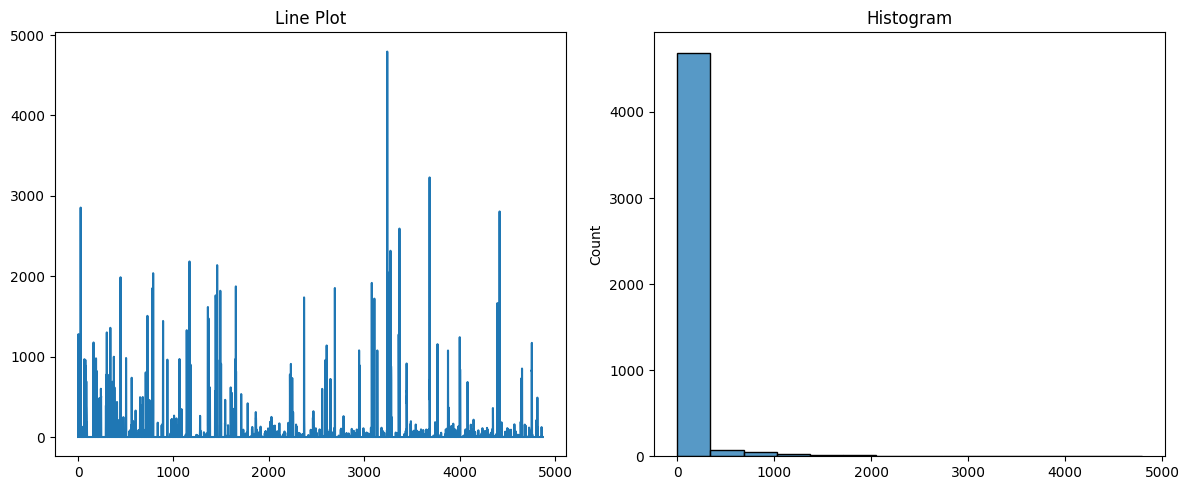

In [21]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot on each subplot
sns.lineplot(data=activity_matrix[:,NEURON_IDX], ax=ax1)
ax1.set_title('Line Plot')

sns.histplot(data=activity_matrix[:,NEURON_IDX], ax=ax2)
ax2.set_title('Histogram')

plt.tight_layout()
plt.show()

In [22]:
selected_data = np.log1p(activity_matrix[:, NEURON_IDX])  # log(1 + x)
# Then min-max normalize
min_vals = np.min(selected_data, axis=0, keepdims=True)
max_vals = np.max(selected_data, axis=0, keepdims=True)
selected_data = (selected_data - min_vals) / (max_vals - min_vals + 1e-8)
print(f"After log1p + minmax: [{selected_data.min():.3f}, {selected_data.max():.3f}]")

After log1p + minmax: [0.000, 1.000]


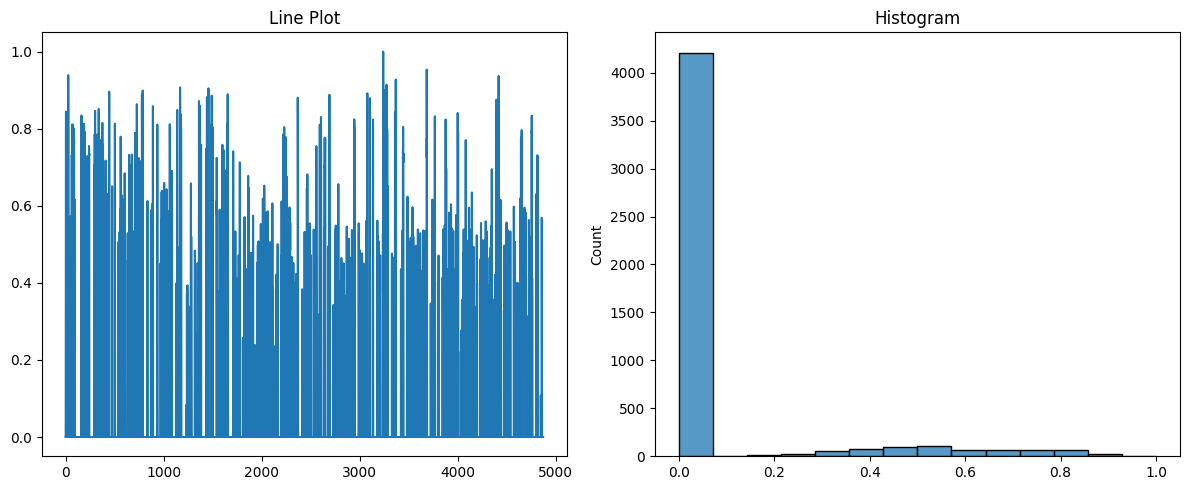

In [27]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot on each subplot
sns.lineplot(data=selected_data, ax=ax1)
ax1.set_title('Line Plot')

sns.histplot(data=selected_data, ax=ax2)
ax2.set_title('Histogram')

plt.tight_layout()
plt.show()

In [3]:
session.eid

'61f260e7-b5d3-4865-a577-bcfc53fda8a8'

In [2]:
one.cache_dir

WindowsPath('C:/Users/Gugu/Downloads/ONE/alyx.internationalbrainlab.org')

In [ ]:
pth_meso = Path(one.cache_dir, 'meso')

In [ ]:
def plot_xyz(eid, mapping='isort', axoff=False, ax=None):

    '''
    3d plot of cell locations
    '''

    r = np.load(Path(pth_meso, 'data', f"{eid}.npy"), 
                      allow_pickle=True).item()
                      
    alone = False
    if not ax:
        alone = True
        fig = plt.figure(figsize=(8.43,7.26), label=mapping)
        ax = fig.add_subplot(111,projection='3d')   
    
    if mapping == 'isort':
        color_values = r['isort'] / r['isort'].max()
        cmap = cm.get_cmap('Spectral')
        cols = cmap(color_values)

    elif mapping == 'regions':
        # cols = r['region_colors']  # too simlar colors
        regs = np.unique(r['region_labels'])   
        region_colors_d = dict(zip(regs,load_distinct_bright_colors(n=len(regs))))
        cols = np.array([region_colors_d[reg] 
            for reg in r['region_labels']])

In [5]:
from one.api import ONE
from iblutil.util import Bunch
from iblatlas.atlas import AllenAtlas
import numpy as np
import matplotlib.pyplot as plt
from collections  import Counter
from rastermap import Rastermap
from pathlib import Path
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba, hsv_to_rgb, to_hex
import gc
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
from scipy.stats import zscore

one = ONE()

pth_meso = Path(one.cache_dir, 'meso')
pth_meso.mkdir(parents=True, exist_ok=True)


atlas = AllenAtlas()

adf = atlas.regions.to_df()
region_colors_dict = {
    row['acronym']: f"{row['hexcolor']}"  
    for _, row in adf.iterrows()}


def load_distinct_bright_colors(n=20, saturation=0.9, brightness=0.95):
    hues = np.linspace(0, 1, n, endpoint=False)
    hsv = np.stack([hues, np.full(n, saturation), np.full(n, brightness)], axis=1)
    rgb = hsv_to_rgb(hsv)
    hex_colors = [to_hex(c) for c in rgb]
    return hex_colors


def embed_meso(eid, scaling=True):

    '''
    Load and embed mesoscope data via rastermap for a given experiment ID (eid).
    Parameters:
    - eid: str, experiment ID
    eid = '71e53fd1-38f2-49bb-93a1-3c826fbe7c13', Sam's example

    query = 'field_of_view__imaging_type__name,mesoscope'
    eids = one.search(procedures='Imaging', django=query, query_type='remote')


    scaling: bool, whether to scale the data by percentile
    '''
    print('Loading mesoscope data for experiment ID:', eid)

    objects = ['mpci', 'mpciROIs', 'mpciROITypes', 'mpciStack']  

    fov_folders = one.list_collections(eid, collection='alf/FOV_*')
    fovs = sorted(map(lambda x: int(x[-2:]), fov_folders))
    nFOV = len(fovs)

    all_ROI_data = Bunch()
    for fov in fov_folders:
        all_ROI_data[fov.split('/')[-1]] = one.load_collection(eid, fov, object=objects)

    roi_signals = []
    roi_timess = []
    region_labelss = []
    region_colorss = []
    xyzs = []

    for fov in all_ROI_data:
        print(fov)
        ROI_data_00 = all_ROI_data[fov]

        # Determine region alignment key
        key = 'brainLocationsIds_ccf_2017' if 'brainLocationsIds_ccf_2017' in ROI_data_00['mpciROIs'] \
            else 'brainLocationIds_ccf_2017_estimate'
        
        region_ids = ROI_data_00['mpciROIs'][key]
        region_labels = atlas.regions.id2acronym(region_ids)


        region_colors = np.array([adf.loc[adf['id'] == i, 
                            'hexcolor'].values[0] for i in region_ids])

        # Data: times and ROI signals
        frame_times = ROI_data_00['mpci']['times']
        roi_xyz = ROI_data_00['mpciROIs']['stackPos']
        timeshift = ROI_data_00['mpciStack']['timeshift']
        roi_offsets = timeshift[roi_xyz[:, len(timeshift.shape)]]
        
        roi_times = np.tile(frame_times, 
                            (roi_offsets.size, 1)) + roi_offsets[np.newaxis, :].T

        # roi_signal = ROI_data_00['mpci']['ROIActivityF'].T  
        roi_signal = ROI_data_00['mpci']['ROIActivityDeconvolved'].T 
        
        print(roi_times.shape[1], 'time bins', 'from ', roi_times[0].min(), 
            'to', roi_times[0].max(), 
            f'bin size: {np.diff(roi_times[0])[0]:.4f} s')

        # filter out neurons only
        mask = ROI_data_00['mpciROIs']['mpciROITypes']
        mask = mask.astype(bool)

        print(fov, sum(mask), 'of', len(mask), 'channels are neurons')

        roi_signals.append(roi_signal[mask])
        roi_timess.append(roi_times)
        region_labelss.append(region_labels[mask])
        region_colorss.append(region_colors[mask])
        xyzs.append(ROI_data_00['mpciROIs']['mlapdv_estimate'][mask])

        
    # stack across fovs    
    roi_signal = np.vstack(roi_signals)
    roi_times = roi_timess[0]  # all fovs have the same time bins
    region_labels = np.hstack(region_labelss)
    region_colors = np.hstack(region_colorss)
    xyz = np.vstack(xyzs)

    print(roi_signal.shape, 'ROI signal shape')
    print(Counter(region_labels))

    if scaling:
        # scaling every trace between its 20th and 99th percentile
        print('Scaling ROI signals...')
        p20 = np.percentile(roi_signal, 20, axis=1, keepdims=True)
        p99 = np.percentile(roi_signal, 99, axis=1, keepdims=True)
        roi_signal = (roi_signal - p20) / (p99 - p20)


    print('Running rastermap...')
    model = Rastermap(n_PCs=100, n_clusters=30,
                    locality=0.75, time_lag_window=5, 
                    bin_size=1).fit(roi_signal)

    isort = model.isort
    roi_signal_sorted = roi_signal[isort]
    region_colors_sorted = region_colors[isort]

    rr = {
        'roi_signal': roi_signal_sorted,
        'roi_times': roi_times,
        'region_labels': region_labels[isort],
        'region_colors': region_colors_sorted,
        'isort': isort,
        'xyz': xyz[isort]}

    dpth = Path(pth_meso, 'data')
    dpth.mkdir(parents=True, exist_ok=True)
    np.save(Path(dpth, f"{eid}.npy"), rr, allow_pickle=True)



def plot_raster(eid, bg=True, alpha=0.3, interp='none', restr=True):


    '''
    restr: restrict to 1 min starting at end of first third of recording
    '''

    rr = np.load(Path(pth_meso, 'data', f"{eid}.npy"), 
                      allow_pickle=True).item()

    # Allen colors are too similar for these visual areas, remap to distinct colors
    regs = np.unique(rr['region_labels'])   
    region_colors_d = dict(zip(regs,load_distinct_bright_colors(n=len(regs))))
    region_colors = np.array([region_colors_d[reg] for reg in rr['region_labels']])


    n_rows, n_time = rr['roi_signal'].shape
    fig, ax = plt.subplots(figsize=(8, 10))

    if restr:
        # Time resolution (samples per second)
        sampling_rate = rr['roi_times'][0].shape[0] / (rr['roi_times'][0].max() - rr['roi_times'][0].min())

        # Number of time bins in 1 minute
        n_1min = int(sampling_rate * 60)

        # Start of second third
        start = n_time // 3

        rr['roi_signal'] = rr['roi_signal'][:, start:start + n_1min]
        rr['roi_times'] = rr['roi_times'][:, start:start + n_1min]

    vmin, vmax = 0, 0.5
    ax.imshow(rr['roi_signal'], cmap='gray_r', aspect='auto', interpolation=interp,
                    extent=[rr['roi_times'][0].min(), rr['roi_times'][0].max(), 0, n_rows], vmin=vmin, vmax=vmax,
                    zorder=1)

    if bg:
        for i, color in enumerate(region_colors):
            ax.fill_between(
                [rr['roi_times'][0].min(), rr['roi_times'][0].max()],
                i, i + 1, facecolor=color, alpha=alpha, linewidth=0
            )

    ax.set_xlabel('Time [s]')
    ax.set_ylabel('rastermap sorted ROIs')

    region_counter = Counter(rr['region_labels'])

    patches = [
        mpatches.Patch(color=region_colors_d[region], label=f"{region} ({count})")
        for region, count in region_counter.items()
    ]

    n_cols = len(patches)  # one column per region
    legend = ax.legend(
        handles=patches,
        loc='lower center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=min(6, n_cols if n_cols <= 3 else n_cols // 2),
        frameon=False,
        fontsize='small'
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.colorbar(im, ax=ax, label='Activity (dF/F)')
    plt.tight_layout()
    fig.savefig(Path(pth_meso, 
        f"{eid}_{'_'.join(np.unique(rr['region_labels']))}_{'_'.join([str(x) for x in rr['roi_signal'].shape])}.png"), dpi=300)
    #plt.close()


# if __name__ == "__main__":
#     # Query for all mesoscope experiments
#     query = 'field_of_view__imaging_type__name,mesoscope'
#     eids = one.search(procedures='Imaging', django=query, query_type='remote')

#     print(f"Found {len(eids)} mesoscope experiment IDs.")

#     for eid in eids:
#         try:
#             print(f"\nProcessing {eid}")
#             embed_meso(eid)
#             plot_meso(eid)
#         except Exception as e:
#             print(f"Failed to process {eid}: {e}")



def plot_xyz(eid, mapping='isort', axoff=False, ax=None):

    '''
    3d plot of cell locations
    '''

    r = np.load(Path(pth_meso, 'data', f"{eid}.npy"), 
                      allow_pickle=True).item()
                      
    alone = False
    if not ax:
        alone = True
        fig = plt.figure(figsize=(8.43,7.26), label=mapping)
        ax = fig.add_subplot(111,projection='3d')   
    
    if mapping == 'isort':
        color_values = r['isort'] / r['isort'].max()
        cmap = cm.get_cmap('Spectral')
        cols = cmap(color_values)

    elif mapping == 'regions':
        # cols = r['region_colors']  # too simlar colors
        regs = np.unique(r['region_labels'])   
        region_colors_d = dict(zip(regs,load_distinct_bright_colors(n=len(regs))))
        cols = np.array([region_colors_d[reg] 
            for reg in r['region_labels']])



    xyz = r['xyz'] / 1000  # isorted xyz coordinates; in mm
    


       
    ax.scatter(xyz[:,0], xyz[:,1],xyz[:,2], depthshade=False,
               marker='o', s = 1 if alone else 0.5, c=cols)
               
                       
    scalef = 1                 
    ax.view_init(elev=45.78, azim=-33.4)
    ax.set_xlim(min(xyz[:,0])/scalef, max(xyz[:,0])/scalef)
    ax.set_ylim(min(xyz[:,1])/scalef, max(xyz[:,1])/scalef)
    ax.set_zlim(min(xyz[:,2])/scalef, max(xyz[:,2])/scalef)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    fontsize = 14
    ax.set_xlabel('x [mm]', fontsize = fontsize)
    ax.set_ylabel('y [mm]', fontsize = fontsize)
    ax.set_zlabel('z [mm]', fontsize = fontsize)
    ax.tick_params(axis='both', labelsize=12)
    #ax.set_title(f'Mapping: {mapping}')
    ax.grid(False)
    nbins = 3
    ax.xaxis.set_major_locator(MaxNLocator(nbins=nbins))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=nbins))
    ax.zaxis.set_major_locator(MaxNLocator(nbins=nbins))

    if axoff:
        ax.axis('off')

    ax.set_title(f'color: {mapping} \n eid = {eid}')

    # Add legend with region label names and colors
    if mapping == 'regions':
        handles = [
            mpatches.Patch(color=region_colors_d[reg], label=reg)
            for reg in sorted(regs)
        ]
        if alone:
            # Create a separate legend outside the 3D plot if standalone
            fig.subplots_adjust(right=0.75)
            ax.legend(handles=handles, loc='center left',
                      bbox_to_anchor=(1.05, 0.5),
                      fontsize='small', frameon=False)
        else:
            # Add legend inside current axes if ax was passed
            ax.legend(handles=handles, loc='upper right',
                      fontsize='small', frameon=False)

Loading mesoscope data for experiment ID: 61f260e7-b5d3-4865-a577-bcfc53fda8a8
FOV_02
19081 time bins from  1.1737215062608537 to 3935.1687215062607 bin size: 0.2050 s
FOV_02 1288 of 4491 channels are neurons
FOV_04
19081 time bins from  1.2254867595616157 to 3935.2204867595615 bin size: 0.2050 s
FOV_04 640 of 3080 channels are neurons
FOV_03
19081 time bins from  1.1838169770089155 to 3935.1788169770084 bin size: 0.2050 s
FOV_03 546 of 2168 channels are neurons
FOV_00
19081 time bins from  1.1222470689898714 to 3935.11724706899 bin size: 0.2050 s
FOV_00 1076 of 3033 channels are neurons
FOV_06
19081 time bins from  1.261298676371613 to 3935.2562986763714 bin size: 0.2050 s
FOV_06 1018 of 4023 channels are neurons
FOV_07
19081 time bins from  1.2863088549326553 to 3935.2813088549324 bin size: 0.2050 s
FOV_07 1429 of 3780 channels are neurons
FOV_01
19081 time bins from  1.1377434088624108 to 3935.132743408862 bin size: 0.2050 s
FOV_01 1245 of 3470 channels are neurons
FOV_05
19081 time

C:\Users\Gugu\AppData\Local\Temp\ipykernel_344356\3388687887.py:262: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Spectral')


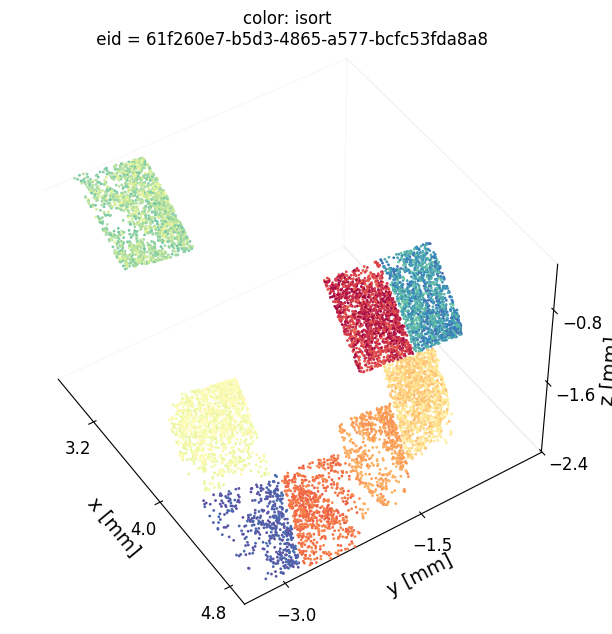

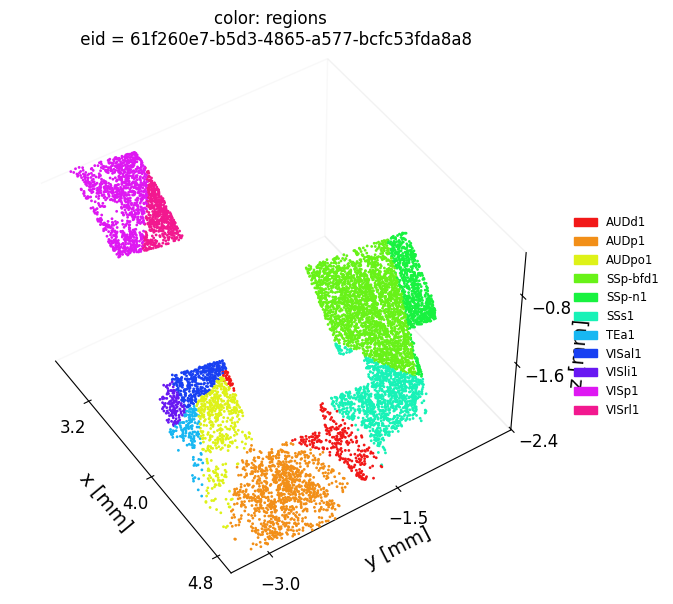

In [9]:
# run 'path/to/data'
eid = session.eid
embed_meso(eid)
plot_xyz(eid, mapping='isort')
plot_xyz(eid, mapping='regions')

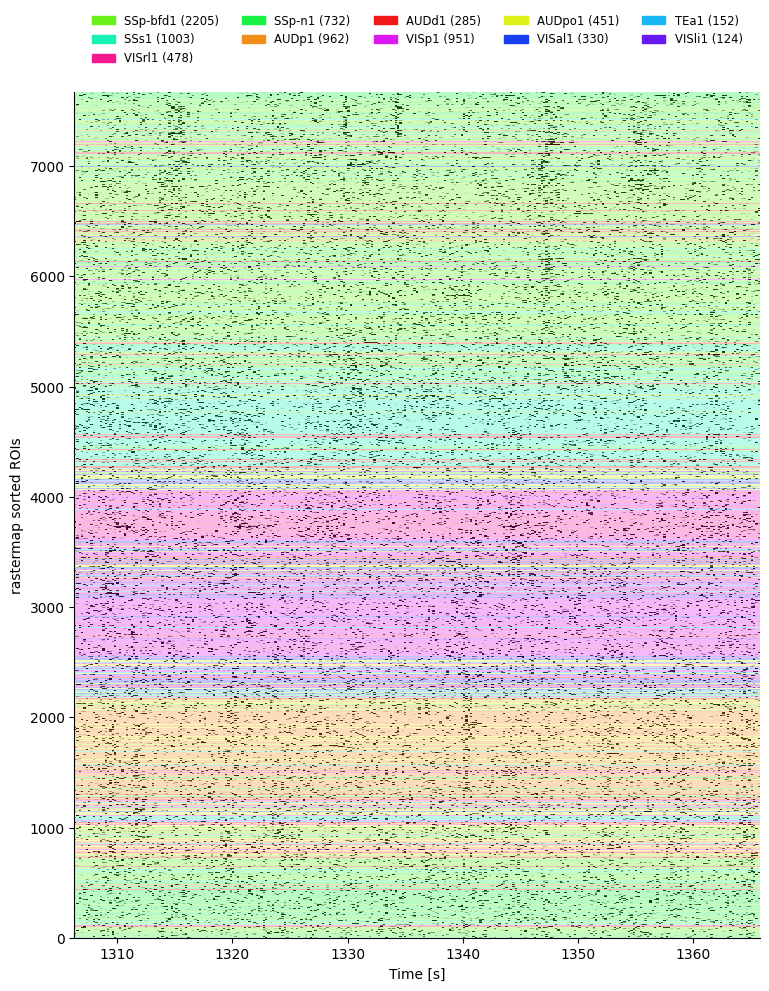

In [10]:
plot_raster(eid=session.eid)